<a href="https://colab.research.google.com/github/AlexSebastianSC/Logic-Regression-and-LSTM-forcasting/blob/main/LogisticRegression%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MODELO LOGIT

#### Para este modelo usaremos data correspondiente al riesgo crediticio que puede presentar un cliente para pagar sus prestamos teniendo como principales features:
#### - 'clientid': Identificador del cliente
#### - 'income'  : Monto de ingresos del cliente
#### - 'age'     : Edad del cliente
#### - 'loan'    : Prestamo que el cliente tiene con el banco
#### - 'default' : 0(pagara), 1 (no pagara) (Variable objetivo)

##### Enlace: https://www.kaggle.com/datasets/upadorprofzs/credit-risk/data

#### 1. Importamos las librerias correspondientes

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Aplicar Oversampling y Undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

#### 2. Leemos e identificamos la informacion con respecto a la naturaleza de nuestros datos

In [ ]:
df = pd.read_csv('original.csv', delimiter=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   clientid  2000 non-null   int64  
 1   income    2000 non-null   float64
 2   age       1997 non-null   float64
 3   loan      2000 non-null   float64
 4   default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.2 KB


#### 3. Identificamos valores vacios

In [ ]:
df = df.drop(columns=['clientid'])
#Verificar valores vacios
for column in df.columns:
  nans = df[column].isna().sum()
  print(f'\tColumn: {column} : {nans}')

	Column: income : 0
	Column: age : 3
	Column: loan : 0
	Column: default : 0


In [ ]:
# Debido a que son solo 3 valores perdidos a comparacion de la data, podemos eliminar estos registros
df = df.dropna()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)

<ipython-input-4-dd0a3e648b57>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['index'], inplace=True)


#### 4. Visualizamos graficamente la distribucion de la data

In [ ]:
# revisamos la dsitribucion de los datos mediante la caja:
def visualizar_distribucion(dataframe):
  fig, axes = plt.subplots(1, 3, figsize=(20, 5),constrained_layout=True)
  fig.suptitle('BOXPLOTS DE I, II and III', ha = 'right')
  my_pal="Blues"

  sns.boxplot(ax=axes[0], data=dataframe, x = "default", y="income", color="skyblue")
  sns.boxplot(ax=axes[1], data=dataframe, x = "default", y="age", color="lightblue")
  sns.boxplot(ax=axes[2], data=dataframe, x = "default", y="loan",  color="lightsteelblue");

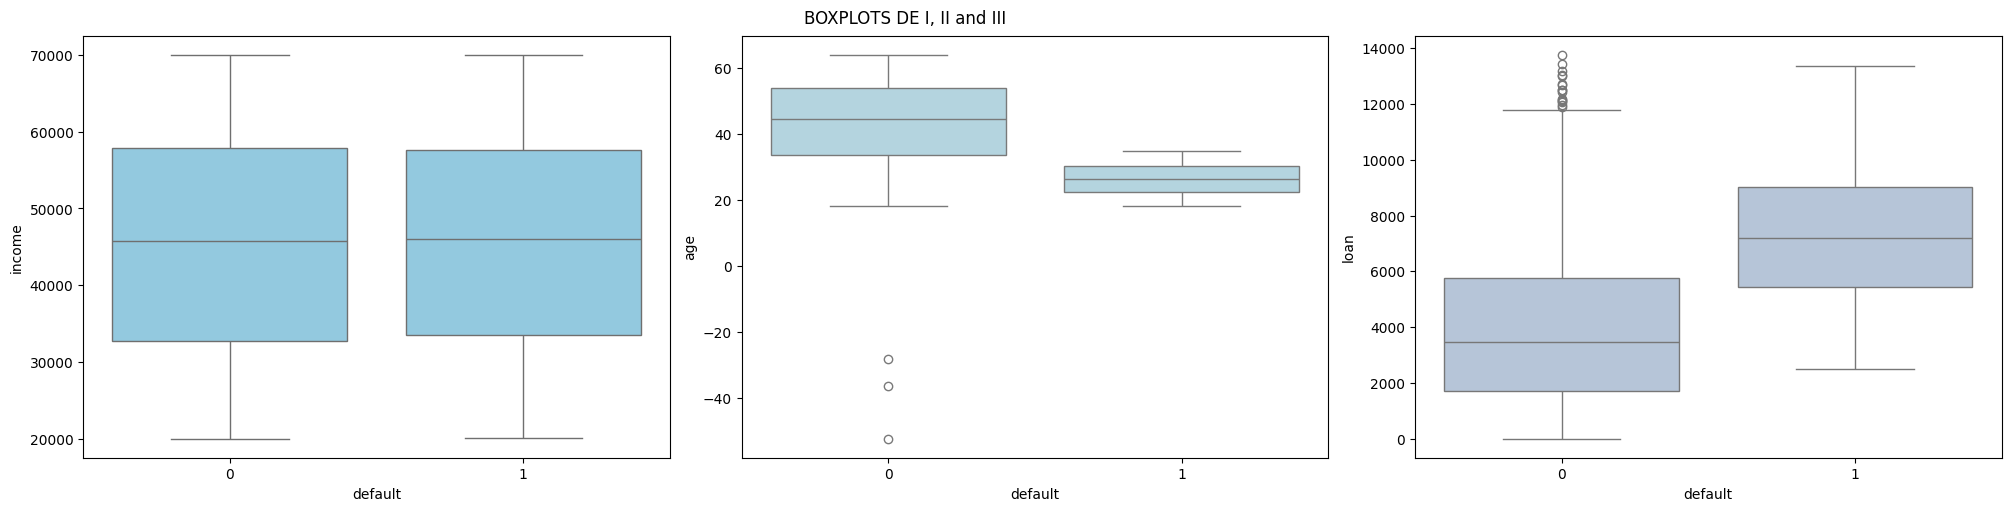

In [ ]:
visualizar_distribucion(df)

##### Identificamos que existen valores atipicos en 'age' presentandose valores negativos (edades negativas) y en 'loan' en donde vemos valores sobre el rango percentil.

In [ ]:
# Calculando cantidad de outliers
def encontrando_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers

def imprimiendo_outliers(dataframe):
  # Crear un DataFrame para almacenar la cantidad de outliers por campo
  outliers_count = pd.DataFrame(columns=['Column', 'Outliers Count'])

  # Iterar sobre cada columna y calcular la cantidad de outliers
  for column in dataframe.columns:
      if dataframe[column].dtype != 'object':  # Solo considerar columnas numéricas
          outliers = encontrando_outliers(dataframe[column])
          outliers_count = outliers_count.append({'Column': column, 'Outliers Count': outliers.sum()}, ignore_index=True)

  # Mostrar el DataFrame con la cantidad de outliers por campo
  print(outliers_count)

##### Identificamos las cantidades de outliers de nuestra data, en este caso nos interesa los presentes en 'age' y 'loan'

In [ ]:
imprimiendo_outliers(df)

    Column Outliers Count
0   income              0
1      age              3
2     loan              3
3  default            283


<ipython-input-7-2692e0d96828>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers_count = outliers_count.append({'Column': column, 'Outliers Count': outliers.sum()}, ignore_index=True)
<ipython-input-7-2692e0d96828>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers_count = outliers_count.append({'Column': column, 'Outliers Count': outliers.sum()}, ignore_index=True)
<ipython-input-7-2692e0d96828>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers_count = outliers_count.append({'Column': column, 'Outliers Count': outliers.sum()}, ignore_index=True)
<ipython-input-7-2692e0d96828>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

#### 5. Tratando Outliers

In [ ]:
# Eliminamos los valores negativos de 'age' (outliers)
df = df[df['age'] >= 0]

# Verificarmos que los valores negativos se hayan eliminado
print(df['age'].describe())

count    1994.000000
mean       40.927700
std        13.271802
min        18.055189
25%        29.043284
50%        41.382673
75%        52.616900
max        63.971796
Name: age, dtype: float64


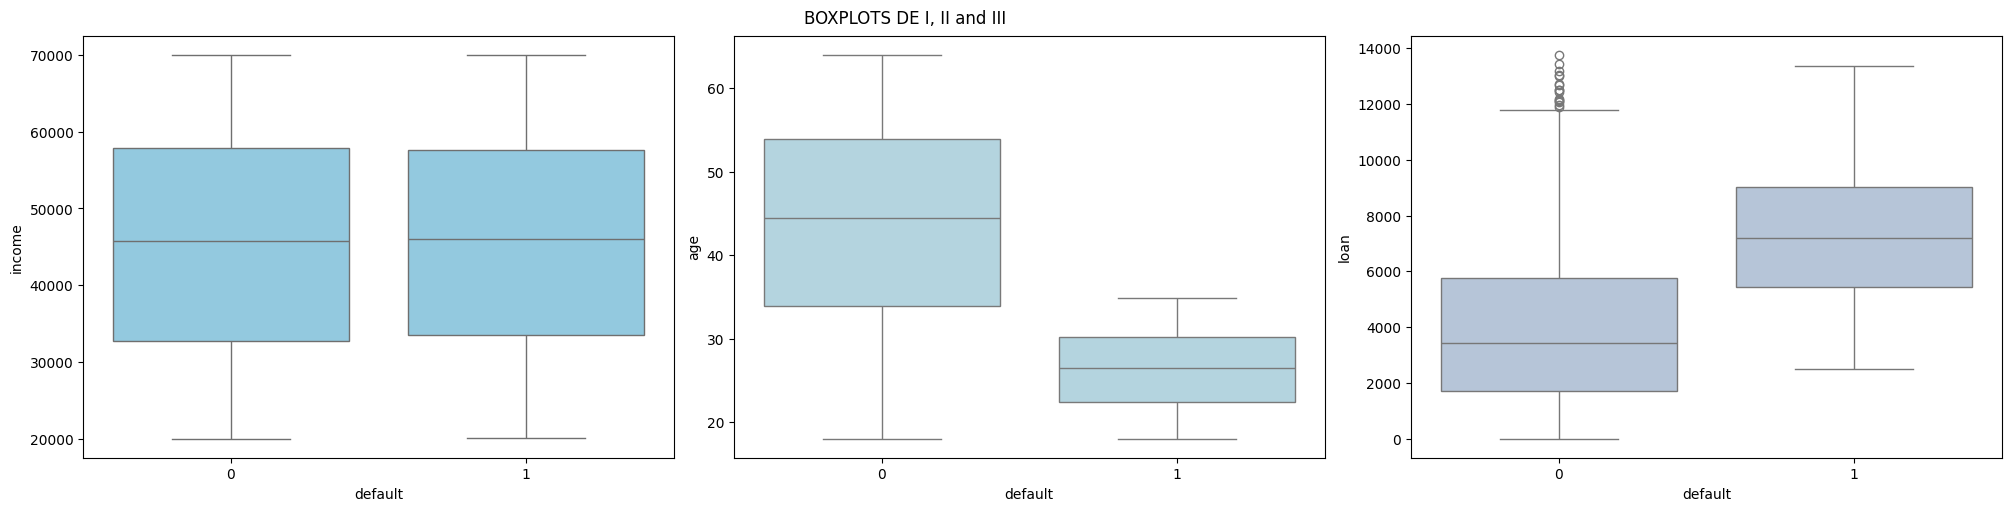

In [ ]:
visualizar_distribucion(df)

In [ ]:
# Calculamos el rango del percentil superior
q3 = df['loan'].quantile(0.75)
iqr = q3 - df['loan'].quantile(0.25)
upper_bound = q3 + 1.5 * iqr

# Identificamos los valores que están por encima del rango del percentil superior
outliers = df[df['loan'] > upper_bound]

# Imprimimos los valores de los outliers
print("Valores por encima del bigote superior:")
print(outliers)

Valores por encima del bigote superior:
            income        age          loan  default
1375  69755.320163  44.543682  13766.051239        0
1581  67289.585683  26.727400  13376.797706        1
1798  67802.694456  49.037987  13443.473176        0


In [ ]:
# Reemplazamos los outliers por el último valor mayor del rango percentil
df.loc[df['loan'] > upper_bound, 'loan'] = upper_bound

# Verificamos que los outliers hayan sido reemplazados correctamente
print("Valores reemplazados por encima del bigote superior:")
print(df[df['loan'] > upper_bound])

Valores reemplazados por encima del bigote superior:
Empty DataFrame
Columns: [income, age, loan, default]
Index: []


#### 6. Verificando la distribucion de la variable objetivo

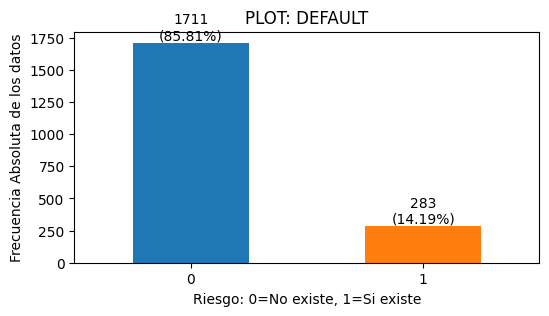

In [ ]:
value_counts = df['default'].value_counts()

# Gráfico
ax = value_counts.plot(kind='bar', color=['C0', 'C1'], figsize=(6, 3), rot=0)
ax.set_title('PLOT: DEFAULT')
ax.set_xlabel('Riesgo: 0=No existe, 1=Si existe')
ax.set_ylabel('Frecuencia Absoluta de los datos')

# Agregamos datos respectivo a la grafica
total_datos = value_counts.sum()
for i, count in enumerate(value_counts):
    porcentaje = (count / total_datos) * 100
    ax.text(i, count, f'{count}\n({porcentaje:.2f}%)', ha='center', va='bottom')

plt.show()

##### Debido a la dsitrubucion aplicamos Oversampling en este caso para poder tener una distribucion mas homogenea; sin embargo evaluaremos su performance cuando entrenemos el modelo junto con la distribucion actual.

In [ ]:
# Aplicamos oversampling a la clase minoritaria (1)
df_minority_upsampled = resample(df[df['default'] == 1],
                                 replace=True,     # Muestreo con reemplazo
                                 n_samples=int(len(df[df['default'] == 0]) * 0.7),  # Aplicamos el 70% de la clase mayoritaria
                                 random_state=42)

# Combina los DataFrames originales y los datos de oversampling para formar un conjunto de datos balanceado
df_balanced = pd.concat([df, df_minority_upsampled])
df_balanced

,income,age,loan,default
0,66155.925095,59.017015,8106.532131,0
1,34415.153966,48.117153,6564.745018,0
2,57317.170063,63.108049,8020.953296,0
3,42709.534201,45.751972,6103.642260,0
4,66952.688845,18.584336,8770.099235,1
...,...,...,...,...
399,58079.156901,18.663027,11540.045812,1
455,21412.308612,26.382710,2639.710126,1
991,43029.803263,27.210157,6894.165381,1
418,53422.216249,28.188531,7441.759617,1


#### Si bien podemos elegir el enfoque Undersampling los datos originales de clase 0 se verian muy simplicados en comparacion a la original, perderiamos mas de la mitad de los datos.

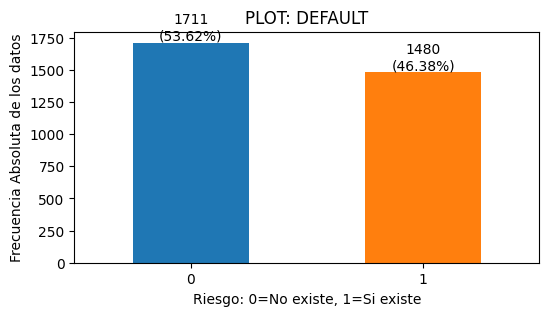

In [ ]:
# Gráfico de barras
ax = value_counts.plot(kind='bar', color=['C0', 'C1'], figsize=(6, 3), rot=0)
ax.set_title('PLOT: DEFAULT')
ax.set_xlabel('Riesgo: 0=No existe, 1=Si existe')
ax.set_ylabel('Frecuencia Absoluta de los datos')

# Agregar datos de las cantidades respectivas
total_datos = value_counts.sum()
for i, count in enumerate(value_counts):
    porcentaje = (count / total_datos) * 100
    ax.text(i, count, f'{count}\n({porcentaje:.2f}%)', ha='center', va='bottom')

plt.show()

#### Al momento de aplicar el Oversampling lo enfocamos en la clase 0 debido a que presentaba la menor cantidad de valores; sin embargo, generemos data que podria ayudar o no en el comportamiento del modelo.

#### 7. Modelamiento

##### En este caso trabajharemos con el modelo de regresion logistica, debido a que nuestro dato es discreto. Usaremos la dsitribucion 80,10,10 (entrenamiento, validacion, test)

In [ ]:
def modelar_datos(dataframe):
  # Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%)
  X_train, X_test, y_train, y_test = train_test_split(dataframe.drop('default', axis=1), dataframe['default'], test_size=0.2, random_state=42)

  # Dividimos los datos de prueba en conjuntos de validación (50% de los datos de prueba)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

  # Entrenamos el modelo
  model = LogisticRegression()
  model.fit(X_train, y_train)



  # Predecimos en el conjunto de validación
  y_val_pred = model.predict(X_val)

  # Calculamos la precisión en el conjunto de validación
  accuracy_val = accuracy_score(y_val, y_val_pred)
  print("Precisión en el conjunto de validación:", accuracy_val)



  # Predecimos en el conjunto de prueba
  y_test_pred = model.predict(X_test)

  # Calculamos la precisión en el conjunto de prueba
  accuracy_test = accuracy_score(y_test, y_test_pred)
  print("Precisión en el conjunto de prueba:", accuracy_test)



  # Matriz de confusión
  conf_matrix = confusion_matrix(y_test, y_test_pred)

  # Graficamos la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Valores Predichos')
  plt.ylabel('Valores Reales')
  plt.title('Matriz de Confusión')
  plt.show()

  return model

##### * En este primer modelo usaremos la data desbalanceada, la original con la limpieza de datos que hicimos pero manteniendo la relacion 86%(clase 0) y 14%(clase 1)

Precisión en el conjunto de validación: 0.9045226130653267
Precisión en el conjunto de prueba: 0.94


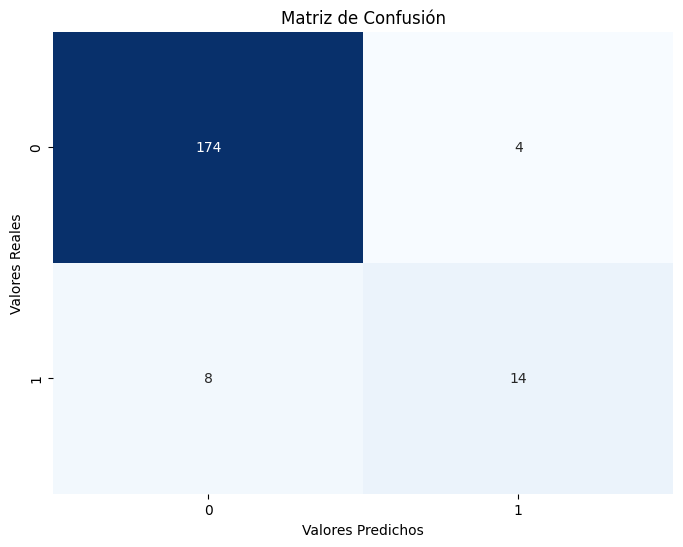

In [ ]:
model_unbalanced_data = modelar_datos(df)

##### Podemos ver que la presicion sobre el conjunto de prueba ha sido del 94% y sobre el conjunto de validacion con un 90%. Esto significa que nuestro modelo con la data sin balancear ya presenta un buen rendimiento.

##### * En es este segundo modelo, los construiremos en base a la data balanceada por oversampling

Precisión en el conjunto de validación: 0.8746081504702194
Precisión en el conjunto de prueba: 0.825


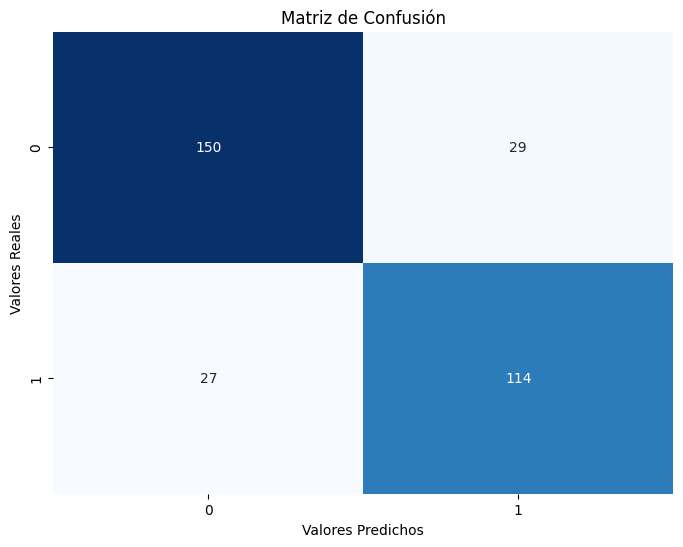

In [ ]:
model_balanced_data = modelar_datos(df_balanced)

##### Podemos ver que la presicion sobre el conjunto de preuba ha sido del 82% y sobre el conjunto de validacion de un 87%, esto puede llevar a un sobreajuste de nuestro modelo, evidenciando que el tratar balancear la data de tal manera que incurrimos en su naturaleza generando mas datos nos lleva a un posible caso de overfitting; es decir el modelo se ajusta demasiado bien a los datos de entrenamiento y captura el ruido y la aleatoriedad en lugar de los patrones subyacentes en los datos.

#### 8. Metricas

##### Aplicamos la metrica ROC sobre nuestros modelos para poder evaluarla relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)

In [ ]:
def ROC_val(model, dataframe):
  # Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%)
  X_train, X_test, y_train, y_test = train_test_split(dataframe.drop('default', axis=1), dataframe['default'], test_size=0.2, random_state=42)

  # Obtener las probabilidades de predicción para la clase positiva
  y_proba = model.predict_proba(X_test)[:, 1]

  # Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
  fpr, tpr, thresholds = roc_curve(y_test, y_proba)

  # Calcular el área bajo la curva ROC (AUC)
  roc_auc = roc_auc_score(y_test, y_proba)

  # Graficar la curva ROC
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc='lower right')
  plt.show()

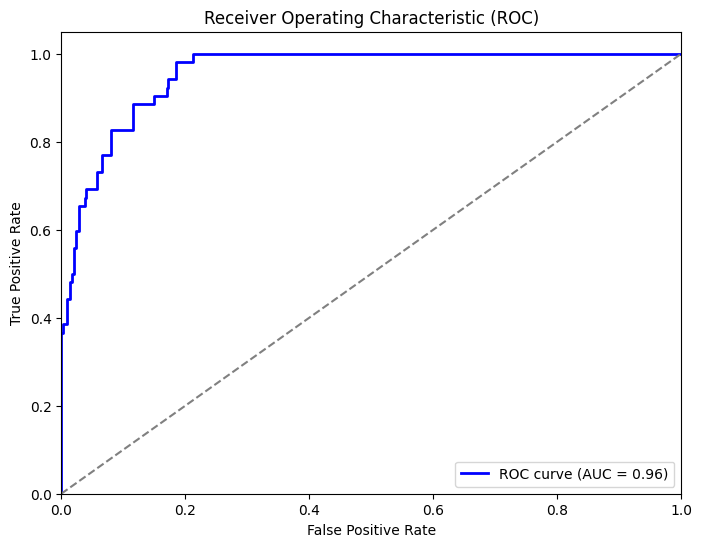

In [ ]:
ROC_val(model_unbalanced_data, df)

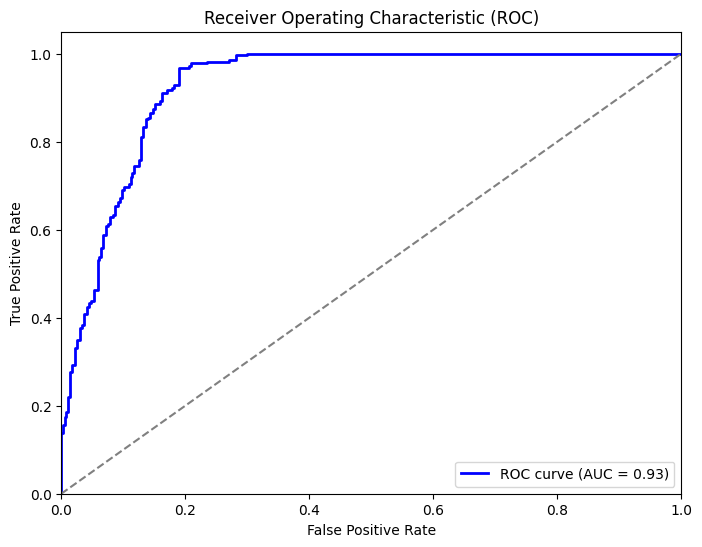

In [ ]:
ROC_val(model_balanced_data, df_balanced)

##### Bajo esta metrica nuestro modelo sin balancear datos mediante oversampling tiene un AUC de 0.93, siendo al menor al modelo sin balancear de 0.96, teniendo este ultimo una mejor performance para identificar las clases negativas y positivas

#### 9. Conclusiones
##### - El tratamientos de outliers es importante debido a que nos permite no solo encontrar valores fuera de serie que pueden influir negativamente en el entrenamiento de nuestro modelo.
##### - Los valores perdidos en casos donde no implica una porcentaje minimo de la totalidad de los datos (ejemplo: 5%), podria resolverse eliminando los mismos; sin embargo debe considerar en caso tener un porcenta de datos missing mas elevado, tratar de buscar informacion para complementarla o en otro sentido aplicar estadisticas (como la media) para poder completarlas.
##### - Si bien para poder entrenar nuestros datos como princioio gneral se busca una dsitribucion normal de los datos, no siempre es bueno hacer un balance radical si tenemos datos con una escala original muy diferenciable, se tiene que optar mas por la escalabilidad de los mismo que por buscar una normalizacion, en casos.

### RRNN modelo de prediccion de acciones de Amazon

#### El siguiente modelo usaremos data sobre las acciones diarias de Amazon en el mercado financiero. Tenemos las siguientes caracteristicas:
#### - Open: El precio de apertura de la acción en el período de tiempo especificado. Es el precio al que se realizó la primera transacción del día para una acción en particular.

#### - High: El precio más alto alcanzado por la acción durante el período de tiempo especificado. Representa el precio máximo al que se negoció la acción durante el día.

#### - Low: El precio más bajo alcanzado por la acción durante el período de tiempo especificado. Representa el precio mínimo al que se negoció la acción durante el día.

#### - Close: El precio de cierre de la acción en el período de tiempo especificado. Es el precio al que se realizó la última transacción del día para una acción en particular.

#### - Adj Close: El precio de cierre ajustado de la acción en el período de tiempo especificado. Este precio tiene en cuenta cualquier evento corporativo que pueda haber afectado el precio de la acción, como dividendos, desdoblamientos de acciones, etc. (Variable objetivo)

#### - Volume: El volumen de acciones negociadas durante el período de tiempo especificado. Representa la cantidad total de acciones que se compraron y vendieron durante el día.

##### Fuente: https://es.finance.yahoo.com/quote/AMZN/history

#### 1. Instacion e importacion de librerias

##### En este caso instalaremos la libreria yfinance para poder extraer datos de acciones de yahoo

In [ ]:
!pip install yfinance

#### 1. Instalamos las librerias correspondientes

##### En este caso usaremos el enfoque de red neuronal basado en RNN(Redes neuronales recurrentes) en este caso el modelo: **LSTM** ***(Long Short-Term Memory)*** que ha demostrado ser muy efectiva en el procesamiento y la predicción de series temporales debido a que tienen la capacidad de aprender dependencias a largo plazo en los datos, lo que las hace especialmente útiles para tareas donde la información relevante puede estar separada por un período de tiempo significativo.

In [ ]:
# Cargamos datos y modulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Scikit-Learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Particionamiento de datos
from sklearn.model_selection import train_test_split

# Importamos libreria yfinance para extraer datos
import yfinance as yf

from datetime import datetime, timedelta

#### 2. Leemos e identificamos la informacion con respecto a la naturaleza de nuestros datos
##### En este caso trabajaremos con las acciones de Amazon (AMZN)


In [ ]:
begin_date   = datetime(1997,5,14).strftime('%Y-%m-%d')
current_date = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
symbol       = 'AMZN'
df_amz       =  pd.DataFrame()
df_amz       = yf.download(symbol, start= begin_date, end= current_date) #interval='1wk'
df_amz

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...
2024-03-15,176.639999,177.929993,173.899994,174.419998,174.419998,72115500
2024-03-18,175.800003,176.690002,174.279999,174.479996,174.479996,31250700
2024-03-19,174.220001,176.089996,173.520004,175.899994,175.899994,26880900


#### 3. Visualizacion de la serie de tiempo 1997 - 2024 (Act.)

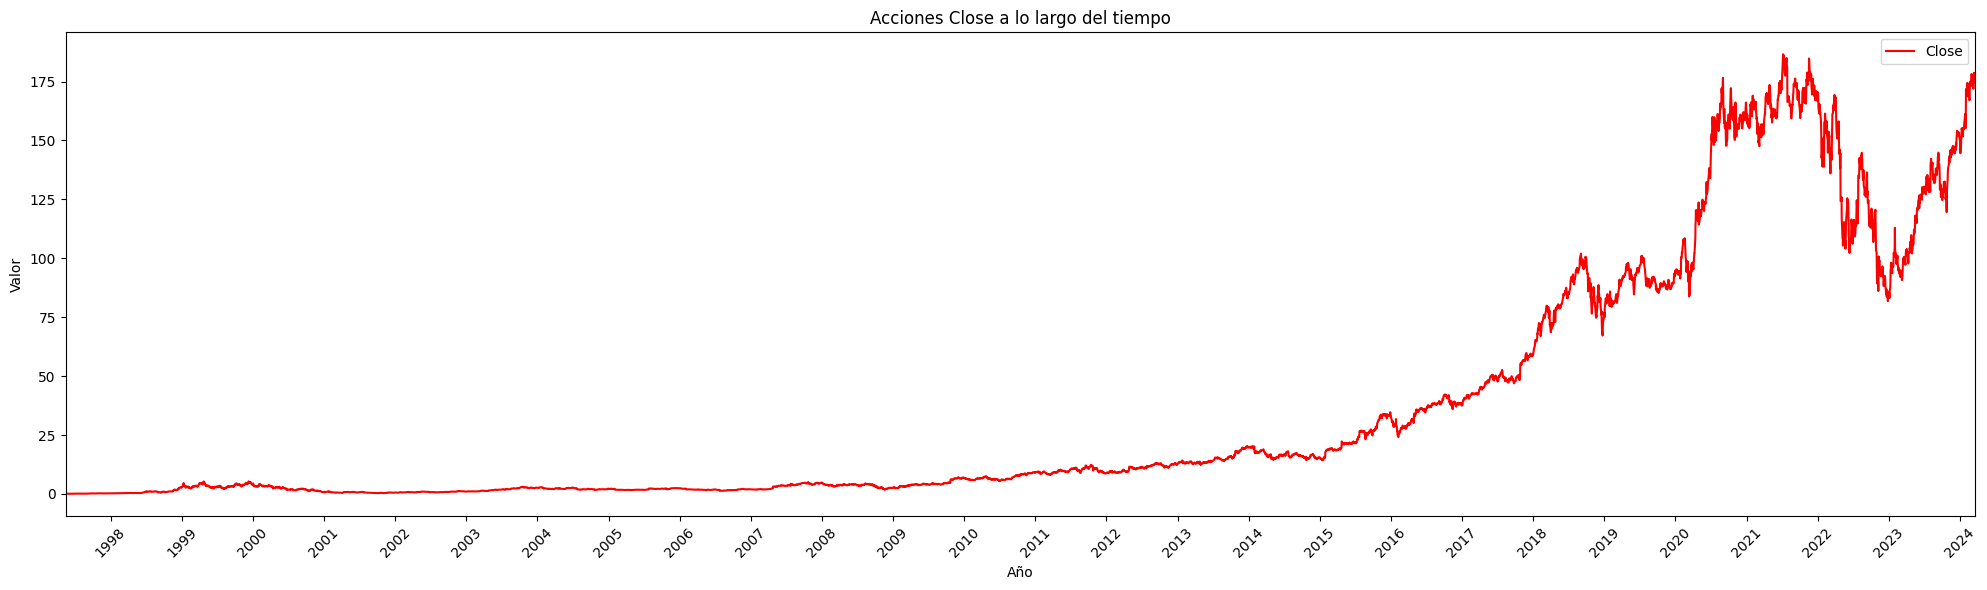

In [ ]:
from matplotlib.dates import YearLocator, DateFormatter

# Copiar el DataFrame
df = df_amz.copy().reset_index()

# Personalizar tamaño px
plt.figure(figsize=(20, 6))

# Graficar las acciones
plt.plot(df['Date'], df['Close'], label='Close', color='red')

years = YearLocator()
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.xlabel('Año')
plt.ylabel('Valor')
plt.title('Acciones Close a lo largo del tiempo')

plt.legend()

# Establecer límites del eje x para coincidir con el rango de las fechas de tus datos
plt.xlim(df['Date'].iloc[0], df['Date'].iloc[-1])

plt.xticks(rotation=45)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

##### Amazon entro a la bolsa en 1997 como una empresa de venta de libros online. Durante el periodo del fenomeno puntocom (1999-2000) pudo sacar beneficos del mismo y sobrevivir a su crisis(esto debido a que ya estaba sentado en el ambiente de online). Podemos observar que las acciones de Amazon empezaron a crecer el la segunda mitad de la primera decada del 2000 debido a su incorporacion a diferentes servicios innovadores como los audios libros y sumando productos en su catalogo de tienda online. Y a partir de la decada del 2010 empiezana  expandir su mercado en europa y otras regiones a la vez que empiezan a incorporar sus servicos en nube.

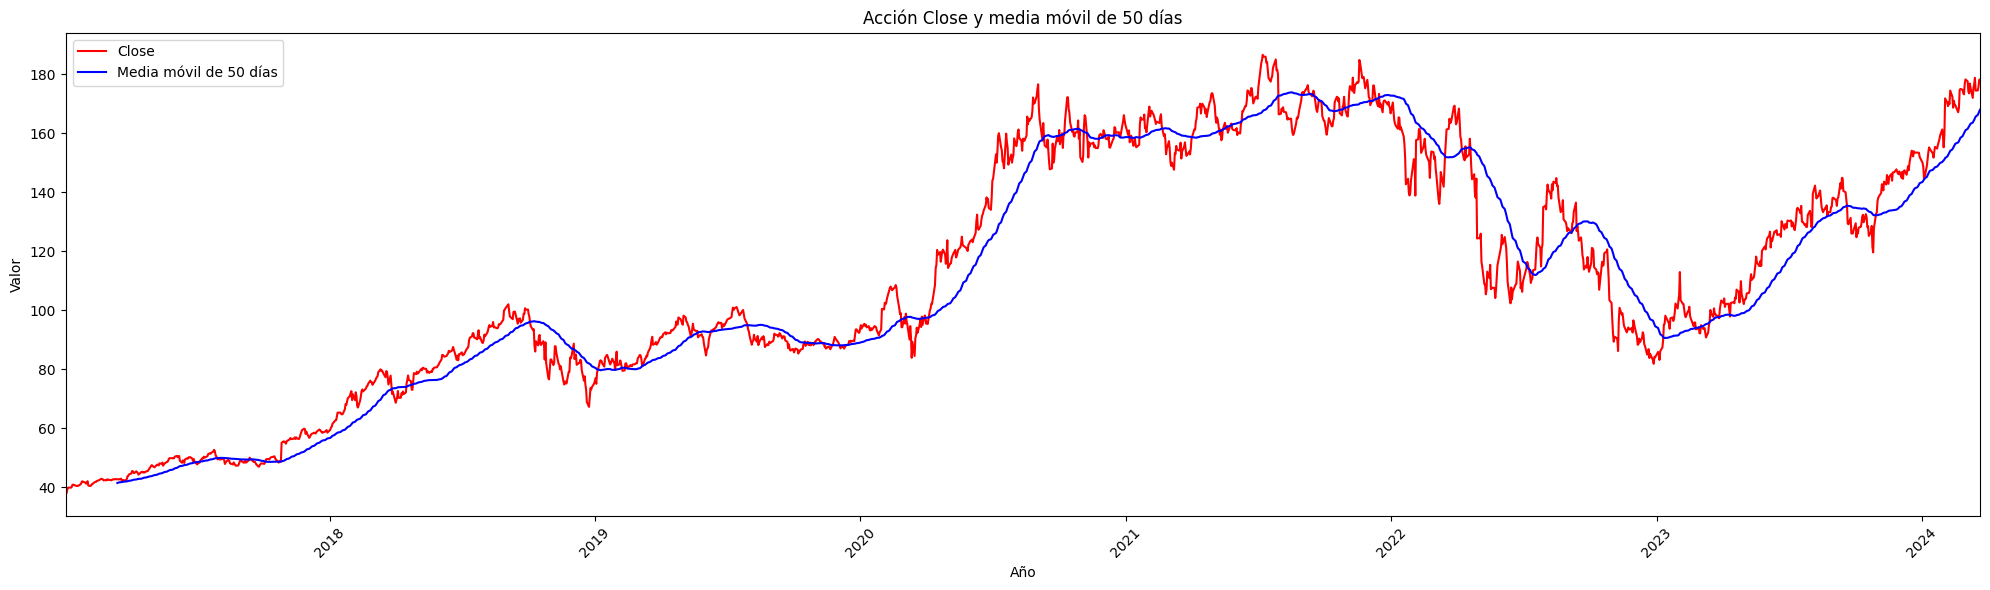

In [ ]:
# Filtramos los datos desde el año 2017 hasta el año 2024
df = df_amz.loc['2017-01-01':'2024-12-31']

plt.figure(figsize=(20, 6))

# Graficar las acciones Close
plt.plot(df.index, df['Close'], label='Close', color='red')

# Trazamos una línea que simule el comportamiento de la acción a lo largo del intervalo de tiempo (media movil = 50 dias)
rolling_mean = df['Close'].rolling(window=50).mean()
plt.plot(df.index, rolling_mean, label='Media móvil de 50 días', color='blue')

years = YearLocator()
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.xlabel('Año')
plt.ylabel('Valor')
plt.title('Acción Close y media móvil de 50 días')

plt.legend()

plt.xlim(df.index[0], df.index[-1])

plt.xticks(rotation=45)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


##### Podemos ver que al rededor del 2017 Amazon tubo picos de crecimiento, esto debido a su nuevos servicios y su expansion. Se puede contemplar que la pandemia en diferencia a perjudicarla, fue su mayor tasa de crecimiento, esto debido al confinamiento y su tienda virtual.

+---+------+----------------+---------------+---------------+---------------+
|   | Año  |     Máximo     | Cierre Máximo |    Mínimo     | Cierre Mínimo |
+---+------+----------------+---------------+---------------+---------------+
| 0 | 2017 | November 2017  |     59.79     | January 2017  |     37.68     |
| 1 | 2018 | September 2018 |    101.98     | January 2018  |     59.45     |
| 2 | 2019 |   July 2019    |    101.05     | January 2019  |     75.01     |
| 3 | 2020 | September 2020 |    176.57     |  March 2020   |     83.83     |
| 4 | 2021 |   July 2021    |    186.57     |  March 2021   |     147.6     |
| 5 | 2022 |  January 2022  |     170.4     | December 2022 |     81.82     |
| 6 | 2023 | December 2023  |    154.07     | January 2023  |     83.12     |
| 7 | 2024 |   March 2024   |    178.75     | January 2024  |    144.57     |
+---+------+----------------+---------------+---------------+---------------+


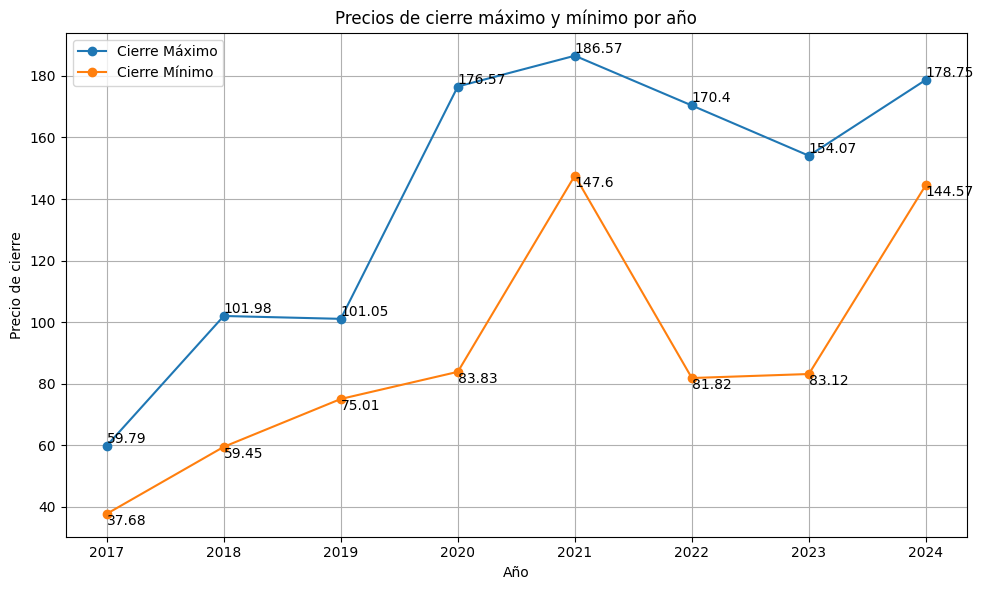

In [ ]:
from tabulate import tabulate

# Convertimos el índice del DataFrame a tipo datetime
df.index = pd.to_datetime(df.index)

# Filtramos datos para los años de interés (2017-2024) y lo agrupamos por a año
df_filtered = df[(df.index.year >= 2017) & (df.index.year <= 2024)]
df_grouped = df_filtered.groupby(df_filtered.index.year)

# Inicializamos listas para almacenar nuestros resultados
resultados = []

# Iteramos los grupos (años)
for year, group in df_grouped:
    max_month_year = group.loc[group['Close'].idxmax()].name
    max_close = group['Close'].max()

    min_month_year = group.loc[group['Close'].idxmin()].name
    min_close = group['Close'].min()

    resultados.append({
        'Año': year,
        'Máximo': f"{max_month_year.strftime('%B')} {max_month_year.year}",
        'Cierre Máximo': round(max_close,2),
        'Mínimo': f"{min_month_year.strftime('%B')} {min_month_year.year}",
        'Cierre Mínimo': round(min_close,2)
    })

# DataFrame con resultados
resultados_df = pd.DataFrame(resultados)

# Tabla
print(tabulate(resultados_df, headers='keys', tablefmt='pretty'))

plt.figure(figsize=(10, 6))
plt.plot(resultados_df['Año'], resultados_df['Cierre Máximo'], label='Cierre Máximo', marker='o')
plt.plot(resultados_df['Año'], resultados_df['Cierre Mínimo'], label='Cierre Mínimo', marker='o')

# Texto en grafica
for i, row in resultados_df.iterrows():
    plt.text(row['Año'], row['Cierre Máximo'], f"{row['Cierre Máximo']}", ha='left', va='bottom')
    plt.text(row['Año'], row['Cierre Mínimo'], f"{row['Cierre Mínimo']}", ha='left', va='top')

plt.xlabel('Año')
plt.ylabel('Precio de cierre')
plt.title('Precios de cierre máximo y mínimo por año')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Podemos apreciar como habiamos previsto que sus acciones no se vieron afectadas por la pandemia, incluso su cierre minimo crecio de 83.83 a 147.6 dolares; sin embargo en el perido alrededor del 2022 hubo una caida importante, esto debido a:
1. La desaceleracion economica de dicha temporada, los aumentos de precios de bienes y servicios en los paises occidentales (esto haciendo que el consumidor tienda a dejar de comprar productos tecnologicos)
2. La reduccion de sus ingresos debido  un proceso de reduccion de costes y decrecimiento de las ventas de su entorno nube AWS.
3. La inversion que hizo para el fabricante de autos electricos Rivian debido a que sus acciones en el 2022 bajaron un 80%, afectando los activos de las finanzas de Amazon.

En cambio en el 2023 hasta la fecha hubo un crecimiento del valor de las acciones esto debido a su estrategia publicitaria digital en diferentes entornos de la red incrementando la demanda de sus diferentes servicios. Ademas de su nueva propues por parte de su servicio AWS en el desarrollo de la IA generativa.

##### En este caso las acciones de Amazon que fueron extraidas de yahoo no presentan valores missing, tan solo valores outilers pertenecientes al periodo total, por ellos para el entrenamiento nos enfocaremos en entrenar datos solo desde el 2017 en donde se muestra el auge de la empresa y de sus acciones que muestran un comportamiento adecuado e interesante para el modelo.

#### 4. Modelado

In [ ]:
# Ordenamos nuetra data debido a su naturaleza de serie de tiempo
df.sort_index(inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,37.896000,37.938000,37.384998,37.683498,37.683498,70422000
2017-01-04,37.919498,37.984001,37.709999,37.859001,37.859001,50210000
2017-01-05,38.077499,39.119999,38.013000,39.022499,39.022499,116602000
2017-01-06,39.118000,39.972000,38.924000,39.799500,39.799500,119724000
2017-01-09,39.900002,40.088501,39.588501,39.846001,39.846001,68922000
...,...,...,...,...,...,...
2024-03-15,176.639999,177.929993,173.899994,174.419998,174.419998,72115500
2024-03-18,175.800003,176.690002,174.279999,174.479996,174.479996,31250700
2024-03-19,174.220001,176.089996,173.520004,175.899994,175.899994,26880900


#### 5. Identificamos valores vacios de nuestro subconjunto

In [ ]:
# Verificamos valores vacios
for column in df.columns:
  nans = df[column].isna().sum()
  print(f'\tColumn: {column} : {nans}')

	Column: Open : 0
	Column: High : 0
	Column: Low : 0
	Column: Close : 0
	Column: Adj Close : 0
	Column: Volume : 0


#### 6. Verificamos periocidad de nuestros datos

In [ ]:
# Verificamos si los datso tienen la misma periocidad
df_time_diffs = df.index.to_series().diff().dt.total_seconds() / (60 * 60 * 24)
print(df_time_diffs.value_counts())

1.0    1423
3.0     325
4.0      51
2.0      16
Name: Date, dtype: int64


##### Podemos observar que nuestra data tiene periocidad diaria(lo que nos interesa) pero tambien tiene datos que tienen entre los mismos un periodo de 2 hasta 4 dias, debemos tratar los mismos debido a que pueden comprometer al resultado de nuestro entrenamiento.

In [ ]:
df_amz_interp = df.asfreq(freq='D', method='bfill')

# Verificamos periocidad establecida
df_time_diffs = df_amz_interp.index.to_series().diff().dt.total_seconds() / (60 * 60 * 24)
print(df_time_diffs.value_counts())

1.0    2634
Name: Date, dtype: int64


In [ ]:
df_amz_interp

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,37.896000,37.938000,37.384998,37.683498,37.683498,70422000
2017-01-04,37.919498,37.984001,37.709999,37.859001,37.859001,50210000
2017-01-05,38.077499,39.119999,38.013000,39.022499,39.022499,116602000
2017-01-06,39.118000,39.972000,38.924000,39.799500,39.799500,119724000
2017-01-07,39.900002,40.088501,39.588501,39.846001,39.846001,68922000
...,...,...,...,...,...,...
2024-03-17,175.800003,176.690002,174.279999,174.479996,174.479996,31250700
2024-03-18,175.800003,176.690002,174.279999,174.479996,174.479996,31250700
2024-03-19,174.220001,176.089996,173.520004,175.899994,175.899994,26880900


##### Verificamos que esta pericidad establecida no afecta a nuestras medias originales significativamente.

In [ ]:
# Verificamos que las medias de los datos originales no se hayan visto afectadas con la interpolacion
for column in df_amz.columns:
  print(f'Promedio "{column}" originales/interpolados: {df_amz[column].mean():.2f} / {df_amz_interp[column].mean():.2f}')

Promedio "Open" originales/interpolados: 111.60 / 111.49
Promedio "High" originales/interpolados: 112.91 / 112.85
Promedio "Low" originales/interpolados: 110.19 / 110.08
Promedio "Close" originales/interpolados: 111.58 / 111.52
Promedio "Adj Close" originales/interpolados: 111.58 / 111.52
Promedio "Volume" originales/interpolados: 79227954.02 / 78913138.56


##### Viendo que no afecta casi en nada, podemos trabajar con esta data para el entrenamiento de nuestro modelo

##### Filtramos nuestra variable predictoria y nuestra variable objetivo

In [ ]:
df_amz_interp.drop(columns=['High','Low','Close','Volume'], inplace =True)
df_amz_interp

,Open,Adj Close
Date,,
2017-01-03,37.896000,37.683498
2017-01-04,37.919498,37.859001
2017-01-05,38.077499,39.022499
2017-01-06,39.118000,39.799500
2017-01-07,39.900002,39.846001
...,...,...
2024-03-17,175.800003,174.479996
2024-03-18,175.800003,174.479996
2024-03-19,174.220001,175.899994


#### 7. Generacion de conjuntos

##### Dividimos nuestra data en la relacion 80,10,10(entrenamiento, validacion, test)

In [ ]:
def train_val_test_split(dataframe, tr_size = 0.8, vl_size = 0.1, ts_size = 0.1):
  # Definir numero de datos en cada subserie
  N      = dataframe.shape[0]
  Ntrain = int(tr_size*N)
  Nvalid = int(vl_size*N)
  Ntest  = N - Ntrain - Nvalid

  # Realizar particion
  train = dataframe[0:Ntrain]
  valid = dataframe[Ntrain: Ntrain + Nvalid]
  test  = dataframe[Ntrain + Nvalid:]

  return train, valid, test

# Prueba de la funcion
tr, vl, ts = train_val_test_split(df_amz_interp)
print(f'Dimesion del set de entrenamiento: {tr.shape}')
print(f'Dimesion del set de entrenamiento: {vl.shape}')
print(f'Dimesion del set de entrenamiento: {ts.shape}')

Dimesion del set de entrenamiento: (2108, 2)
Dimesion del set de entrenamiento: (263, 2)
Dimesion del set de entrenamiento: (264, 2)


##### Visualizamos que parte de nuestra data en la serie de tiempo serviara como entrenamiento(azul), validacion(amarillo) y test(verde)

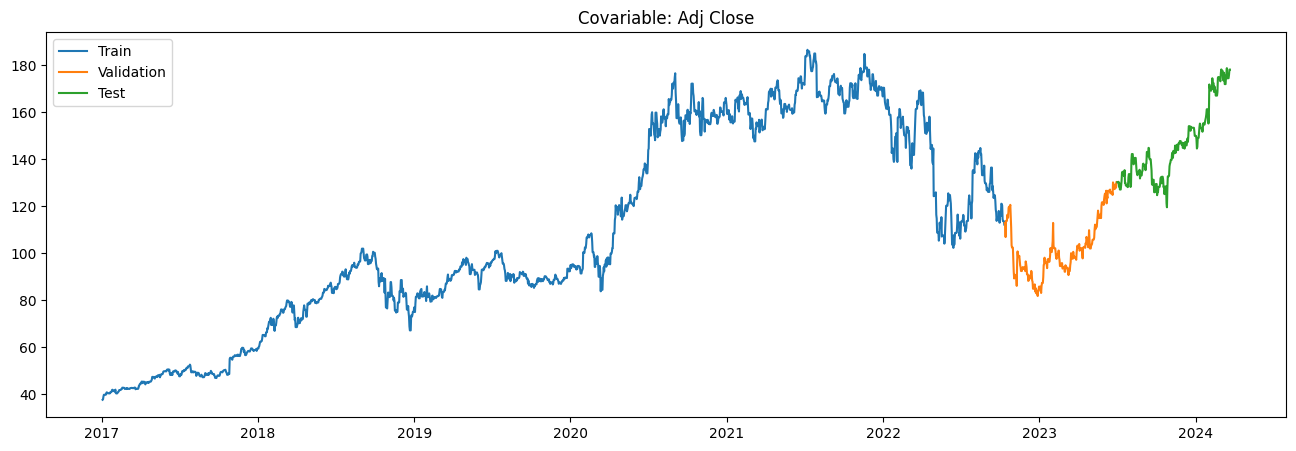

In [ ]:
covar = 1 #Indice de la covariable
col   = df_amz_interp.columns[covar]

# Dibujar los sets de entrenamiento/valdiacion/prueba para la covariable
fig, ax =  plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Validation')
ax.plot(ts[col], label= 'Test')
ax.set_title(f'Covariable: {col}')
plt.legend()

##### Generamos datasets de entrenamiento, recordemos que nuestra red se alimenta de varias entradas y tiene una salida (LSTM Multivariado - Unistep), estos dataset se escogeran secuencialmente en grupos de 15 en donde se predice el de psocion 16, y se correra un espacio para recojer otro dataset, asi secuencialmente sobre todos los datos de la serie de tiempo.

In [ ]:
def crear_dataset_supervisado(array, input_length, output_length):
  X, Y = [], []
  shape =  array.shape

  # Multivariado
  fils, cols = array.shape

  # Generamos los arreglos
  for i in range(fils-input_length-output_length):
    X.append(array[i:i+input_length,0:cols])
    Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

  # Convertimos listas a arreglos de NumPy
  X = np.array(X)
  Y = np.array(Y)

  return X, Y

In [ ]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 15    # Hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (2092, 15, 2), y_tr: (2092, 1, 1)
Set de validación - x_vl: (247, 15, 2), y_vl: (247, 1, 1)
Set de prueba - x_ts: (248, 15, 2), y_ts: (248, 1, 1)


##### Escalamos nuestros valores en un rango de -1 a 1 para poder ser trabajados en serie en nuestra red; esta escala nos permite tener uns representacion de nuestros datos reales.
##### En este caso tenemos como parametros:
##### - data_input: diccionario con los dataset de entrada y salida del modelo (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,'y_ts':y_ts})
##### - col_ref: parámetro adicional para especificar la columna que contiene la variable a predecir

##### La funcion retorna:
##### - data_scaled: diccionario con los datasets de entrada y salida escalado (tiene la misma estructura del diccionario de entrada)
##### - scaler: el escalador usado (requerido para las predicciones)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):

    # Determinar el índice de la columna que contiene la variable a predecir
    col_ref = df_amz_interp.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_input['x_tr'].shape[2]

    # Generamos listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [ ]:
# Escalamiento del dataset con la función anterior

# Creamos diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'Adj Close' )

# Extraemos subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

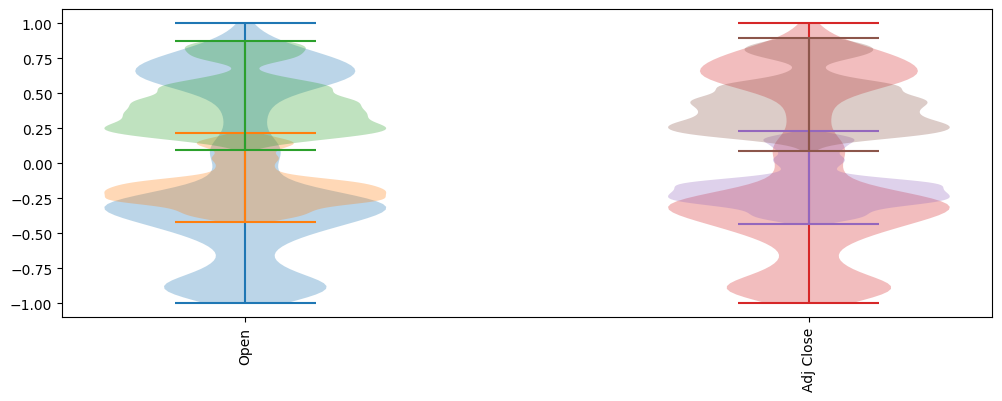

In [ ]:
# Generemos una gráfica tipo violín para ver la distribución de los valores en cada covariable (entrada) y en la variable a predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(2):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(2)))
ax.set_xticklabels(df_amz_interp.keys(), rotation=90)
ax.autoscale();

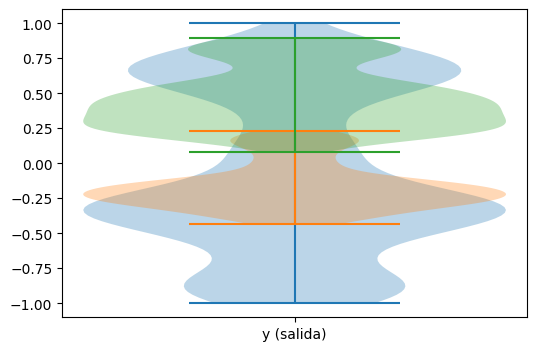

In [ ]:
# Generamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

#### 8. Modelamiento

In [ ]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustamos parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 15 (dias) x 1 (feature)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/80
9/9 - 5s - loss: 0.1993 - val_loss: 0.0693 - 5s/epoch - 591ms/step
Epoch 2/80
9/9 - 1s - loss: 0.0698 - val_loss: 0.0630 - 514ms/epoch - 57ms/step
Epoch 3/80
9/9 - 1s - loss: 0.0667 - val_loss: 0.0619 - 528ms/epoch - 59ms/step
Epoch 4/80
9/9 - 1s - loss: 0.0652 - val_loss: 0.0604 - 518ms/epoch - 58ms/step
Epoch 5/80
9/9 - 1s - loss: 0.0615 - val_loss: 0.0609 - 513ms/epoch - 57ms/step
Epoch 6/80
9/9 - 1s - loss: 0.0616 - val_loss: 0.0585 - 541ms/epoch - 60ms/step
Epoch 7/80
9/9 - 1s - loss: 0.0615 - val_loss: 0.0570 - 524ms/epoch - 58ms/step
Epoch 8/80
9/9 - 1s - loss: 0.0599 - val_loss: 0.0573 - 539ms/epoch - 60ms/step
Epoch 9/80
9/9 - 1s - loss: 0.0587 - val_loss: 0.0556 - 738ms/epoch - 82ms/step
Epoch 10/80
9/9 - 1s - loss: 0.0583 - val_loss: 0.0554 - 874ms/epoch - 97ms/step
Epoch 11/80
9/9 - 1s - loss: 0.0551 - val_loss: 0.0526 - 873ms/epoch - 97ms/step
Epoch 12/80
9/9 - 1s - loss: 0.0575 - val_loss: 0.0540 - 671ms/epoch - 75ms/step
Epoch 13/80
9/9 - 1s - loss: 0.0550 - v

##### Podemos ver que con 80m epocas a medida que avanzamos en cada iteracion, el modelo va teniendo menos perdida al momento de predecir, esto nos indica que el modelo esta prendiendo a predecir.

#### 9. Metricas

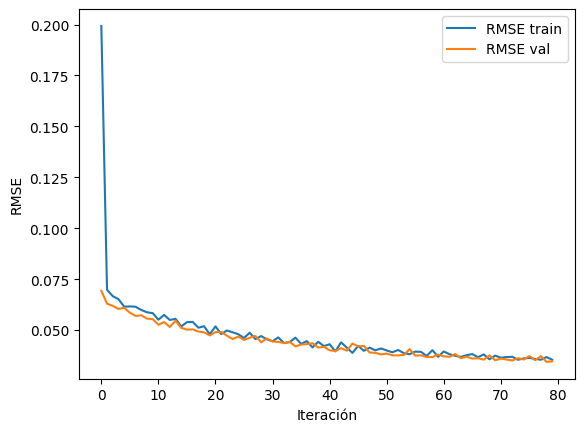

In [ ]:
 # Graficamos curvas de entrenamiento y validación para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

##### Podemos observar que RMSE de entrenamiento va disminuyendo a medida que pasa las epocas, esto interpreta que el modelo está aprendiendo y ajustándose bien a los datos de entrenamiento. Ahora el RMSE de validacion tambiente tiene la misma caracteristica lo que significa que el modelo generaliza bien los nuevos datos. Ambos se estabilizan con el tiempo y se interpreta que no hay overfitting.

In [ ]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.034
  RMSE val:	 0.033
  RMSE test:	 0.038


##### El desempeño del modelo tiene un buen rendimiento y es capaz de hacer predicciones precisas tanto en los datos utilizados para el entrenamiento como en datos nuevos teniendo un RMSE similar.

##### Generamos una funcion para poder predecir instantes futuros con el modelo entrenado teniendo los siguiente:
##### Entrada:
##### - x: batch (o batches) de datos para ingresar al modelo (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
##### - model: Red LSTM entrenada
##### - scaler: escalador (requerido para llevar la predicción a la escala original)

##### Salida:
##### - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)


In [ ]:
def predecir(x, model, scaler):

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

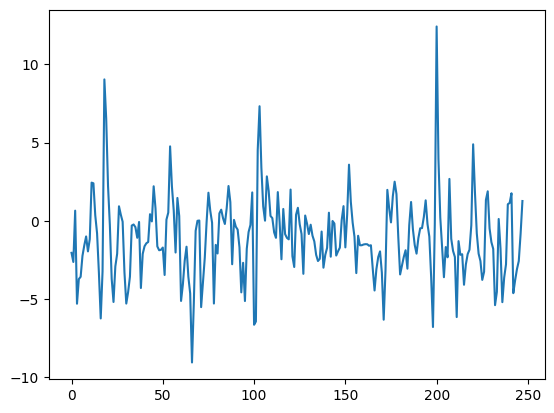

In [ ]:
# Calculamos predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

# Analizamos este desempeño graficamente  mostrando las acciones originales y predichas por el modelo
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

##### Podemos visualizar que en promedio el error es cero, pero hay picos de error entre -10 y 10, esto debido a la votalidad de las acciones. Esto se puede manejar cambiando ciertas caracteristicas del modelo o de la naturaleza de los datos.

#### 10. Conclusiones

##### - LSTM a desmostrado ser una buena alternativa para la prediccion de valores de acciones del mercado; sin embargo; hay que denotar que periodo estamos trabajando, debemos optar por uno que tenga cierta estacionalidad o por lo menos que esten cerca a nuestra temporadad de tal manera que podamos manejar e interpretar la dsitribucion de los mismos y aplicar medidas que nos permitan mejorar la muestra.
##### - Para poder reducir picos de errores debemos afinar los parametros del modelo o realizar una analisis de feauter engenierring mas profunda para ver la importancia respecto a las features frente al dataset.

##### - La red LSTM puede tener variaciones como Univariable-Unistep, Multivariable-Unistep, Univariable= Multistep o Multivariable multistep, dependiendo de la naturales de nuestros datos y el alcance de nuestro proyecto debemos optar por alguna de estas. En nuestro caso el objetivo era poder predecir las acciones del dia.